# Capstone: Airbnb Price Listing Prediction
##### Part 2 - Full EDA and Time Series Analysis

_Authors: Evonne Tham_

<div class="alert alert-block alert-warning">


<b>Checkin 3</b>

The actual deliverable for this section is fairly small. You are expected to submit, via this Google form, a progress report detailing where you are with your Capstone. The format and content is up to you but, at a minimum, we expect the following:


- ~~Do you have data fully in hand and if not, what blockers are you facing?~~
- Have you done a full EDA on all of your data?
- Have you begun the modeling process? How accurate are your predictions so far?
- What blockers are you facing, including processing power, data acquisition, modeling difficulties, data cleaning, etc.? How can we help you overcome those challenges?
- ~~Have you changed topics since your lightning talk? Since you submitted your Problem Statement and EDA? If so, do you have the necessary data in hand (and the requisite EDA completed) to continue moving forward?~~
- ~~What is your timeline for the next week and a half? What do you have to get done versus what would you like to get done?~~
- ~~What topics do you want to discuss during your 1:1?~~
- ~~We will use your progress report as a leaping off point for a deep 1:1 with a member of the instructional staff. The best use of your time is to really flesh out this document so that your remaining time here can be most productive.~~

- Examine the distributions of your data, numerically and/or visually.
- Identify outliers.

</div>

##  1. Import Necessary Libraries & Load Data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

# RdYlGn
# colors = ['#FF5A5F', '#00A699', '#FC642D']
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

final = pd.read_csv('../datasets/final.csv')
# final.drop(columns=['Unnamed: 0'], axis = 1,inplace=True)
print(final.shape)
final.head().T

,0,1,2,3,4
id,35303,197677,289597,370759,700253
host_id,151977,964081,341577,1573631,341577
host_since,2010-06-25,2011-08-13,2011-01-10,2012-01-06,2011-01-10
host_response_time,unknown,within a few hours,within a few hours,within a day,within a few hours
host_response_rate,unknown,100%,100%,100%,100%
host_acceptance_rate,unknown,50-89%,50-89%,90-99%,50-89%
host_is_superhost,0,1,0,1,0
host_listings_count,3,1,2,3,2
host_identity_verified,1,1,1,1,1
neighbourhood_cleansed,Shibuya Ku,Sumida Ku,Nerima Ku,Setagaya Ku,Nerima Ku


##  2. Full Exploratory Analysis

##### Price (Target Variable)

In [45]:
print(f"Nightly advertised prices range from {min(final.price)}¥ to {max(final.price)}¥.")

Nightly advertised prices range from 1075¥ to 1000040¥.


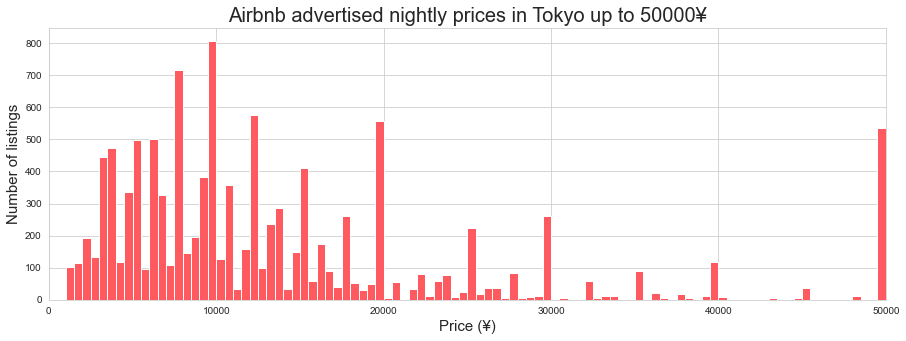

In [30]:
# Distribution of prices up to 50_000 yen 
plt.figure(figsize=(15,5))

final.price.hist(bins=100, 
                 range=(0, 50_000),
                 color ='#FF5A5F')

plt.margins(x=0)
plt.title("Airbnb advertised nightly prices in Tokyo up to 50000¥", fontsize=20)
plt.xlabel("Price (¥)", fontsize=15)
plt.ylabel("Number of listings", fontsize=15);

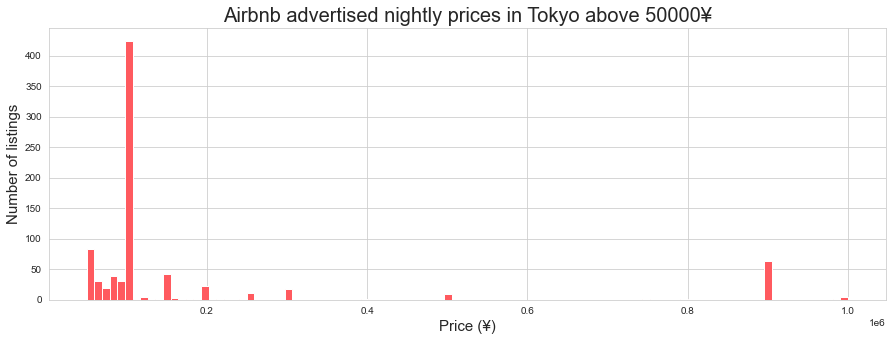

In [36]:
# Distribution of prices up to 50_000 yen 
plt.figure(figsize=(15,5))

final.price.hist(bins=100, 
                 range=(50_000, max(final.price)),
                 color ='#FF5A5F')

plt.title("Airbnb advertised nightly prices in Tokyo above 50000¥", fontsize=20)
plt.xlabel("Price (¥)", fontsize=15)
plt.ylabel("Number of listings", fontsize=15);

In [37]:
final[final['price'] > 100000].sort_values(by='price', ascending=False)

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,time_since_first_review
4560,28502660,215140194,2018-09-13,within an hour,100%,100%,0,5,0,Shibuya Ku,...,100%,10,10,10,10,10,10,1,moderate,0 days 00:00:00.000000000
7538,34131770,255944040,2019-04-15,within an hour,100%,100%,0,1,0,Shibuya Ku,...,50-89%,8,8,9,9,9,8,1,strict,326 days 00:00:00.000000000
10385,39568514,300897462,2019-10-08,within an hour,100%,100%,1,2,1,Shibuya Ku,...,90-99%,10,10,10,10,9,9,1,strict,178 days 00:00:00.000000000
5617,30536245,229126645,2018-12-04,unknown,unknown,100%,0,1,0,Minato Ku,...,90-99%,10,9,10,10,9,9,1,strict,350 days 00:00:00.000000000
10723,40026354,150082965,2017-09-11,within an hour,100%,90-99%,0,6,0,Toshima Ku,...,50-89%,9,10,9,9,9,9,1,moderate,140 days 00:00:00.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8900,36993816,215606612,2018-09-16,within an hour,100%,100%,0,42,0,Toshima Ku,...,90-99%,10,10,9,9,10,9,1,strict,198 days 00:00:00.000000000
8902,36994756,215606612,2018-09-16,within an hour,100%,100%,0,42,0,Toshima Ku,...,90-99%,10,10,9,9,10,10,1,strict,225 days 00:00:00.000000000
313,7620544,39969626,2015-07-29,unknown,unknown,100%,1,3,1,Adachi Ku,...,90-99%,10,10,10,10,9,10,1,moderate,643 days 00:00:00.000000000
5345,30023363,208133335,2018-08-07,within a few hours,100%,100%,1,3,0,Shinjuku Ku,...,100%,10,10,10,10,10,8,1,strict,0 days 00:00:00.000000000


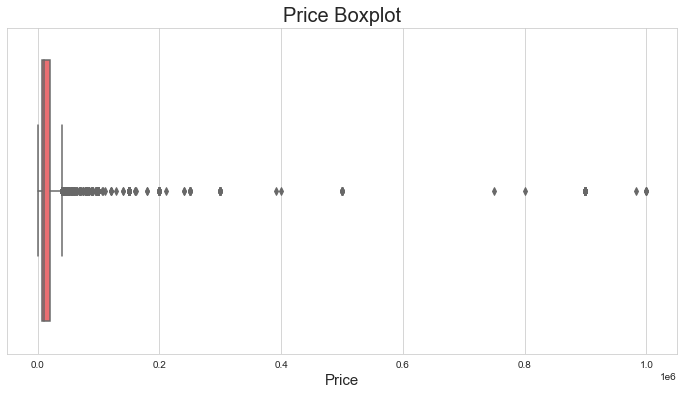

In [39]:
plt.figure(figsize =(12,6))

sns.boxplot(final.price, color = '#FF5A5F')
plt.title('Price Boxplot', fontsize=20)
plt.xlabel('Price', fontsize = 15);

##### Host

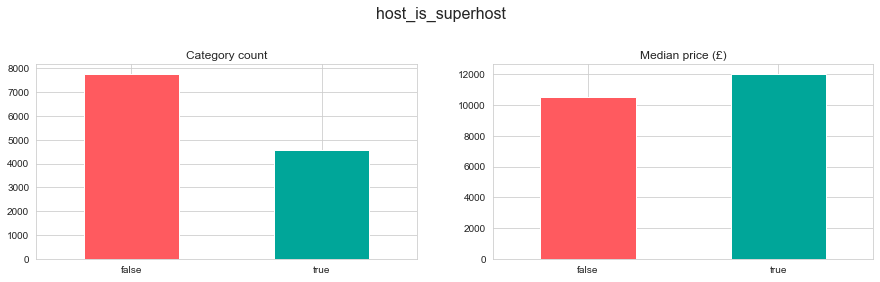

0    0.629738
1    0.370262
Name: host_is_superhost, dtype: float64


In [2]:
def binary_count_and_price_plot(col, figsize=(15,4)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    final.groupby(col).size().plot(kind='bar', ax=ax1, color=['#FF5A5F', '#00A699'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    final.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['#FF5A5F', '#00A699'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()

binary_count_and_price_plot('host_is_superhost')
print(final.host_is_superhost.value_counts(normalize=True));

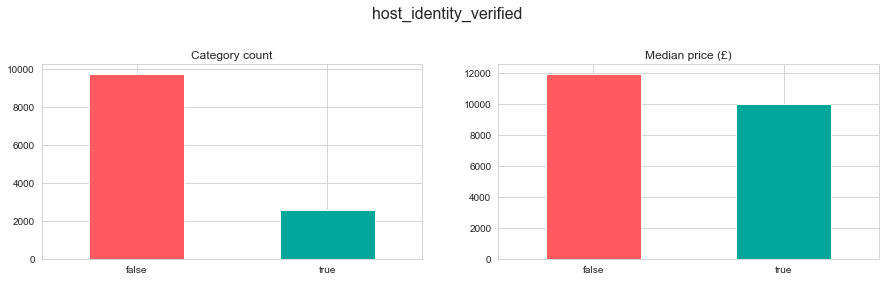

0    0.790735
1    0.209265
Name: host_identity_verified, dtype: float64


In [3]:
binary_count_and_price_plot('host_identity_verified')
print(final.host_identity_verified.value_counts(normalize=True));

<div class="alert alert-block alert-success">

<b>Observation:</b>

About 37% of hosts are superhosts and about 20% of hosts are verified. However, it does not seem to improve the median price per night of their Airbnb listings.
</div>

##### Host Listing Count

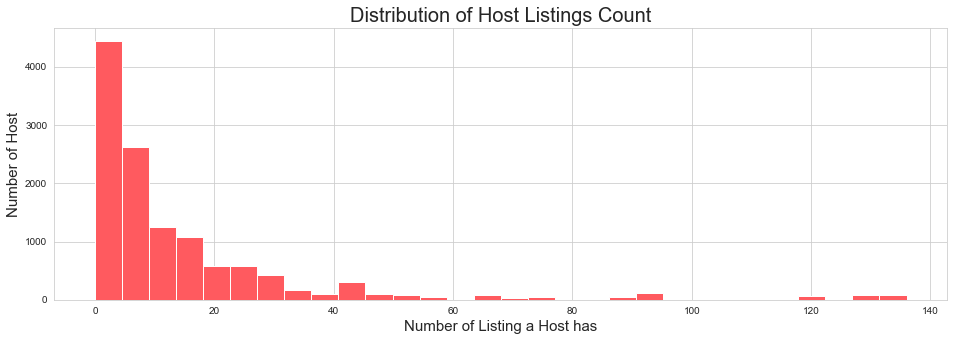

In [4]:
plt.figure(figsize=(16,5))
plt.hist(final['host_listings_count'], bins=30, color ='#FF5A5F')
plt.title('Distribution of Host Listings Count', fontsize=20)
plt.xlabel('Number of Listing a Host has', fontsize=15)
plt.ylabel('Number of Host', fontsize=15);

In [5]:
final[final['host_listings_count']==0]

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,time_since_first_review
18,1394409,7537357,2013-07-17,within a few hours,100%,0-49%,0,0,0,Toshima Ku,...,90-99%,10,9,10,10,10,10,0,moderate,2272 days 00:00:00.000000000
19,1394737,7537357,2013-07-17,within a few hours,100%,0-49%,0,0,0,Toshima Ku,...,90-99%,10,10,10,10,10,10,0,moderate,2334 days 00:00:00.000000000
50,2839061,4839990,2013-01-25,unknown,unknown,50-89%,1,0,0,Bunkyo Ku,...,90-99%,10,10,10,10,10,10,0,strict,1720 days 00:00:00.000000000
151,5198467,25911199,2015-01-10,within a few hours,100%,50-89%,0,0,1,Bunkyo Ku,...,90-99%,10,10,10,10,9,10,0,strict,1857 days 00:00:00.000000000
527,10110295,46443714,2015-10-13,within a day,100%,50-89%,0,0,1,Shibuya Ku,...,90-99%,9,9,9,10,10,9,0,moderate,1516 days 00:00:00.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12323,43198704,255274063,2019-04-11,within an hour,100%,100%,0,0,0,Taito Ku,...,100%,10,10,8,10,10,10,1,strict,0 days 00:00:00.000000000
12324,43230220,343773365,2020-04-13,within an hour,100%,100%,0,0,1,Sumida Ku,...,100%,10,10,10,10,10,10,1,strict,7 days 00:00:00.000000000
12326,43249399,159202994,2017-11-18,within an hour,100%,100%,0,0,0,Ota Ku,...,90-99%,10,10,10,10,9,10,1,flexible,20 days 00:00:00.000000000
12343,43351388,341058704,2020-03-10,within an hour,100%,100%,0,0,0,Edogawa Ku,...,100%,10,10,10,10,10,10,1,strict,0 days 00:00:00.000000000


In [7]:
print("Median number of listings per host:", int(final.host_listings_count.median()))
print("Mean number of listings per host:", int(round(final.host_listings_count.mean())))
print(f"{int(round(100*len(final[final.host_listings_count == 1])/len(final)))}% of listings are from hosts with one listing.")

Median number of listings per host: 7
Mean number of listings per host: 15
10% of listings are from hosts with one listing.


<div class="alert alert-block alert-success">

<b>Observation:</b>

Most host does not have any listing, and some has over 100 listings.


</div>

<div class="alert alert-block alert-warning">

<b>To Do:</b>

Remove Outlier:

- to drop host with zero listings

</div>

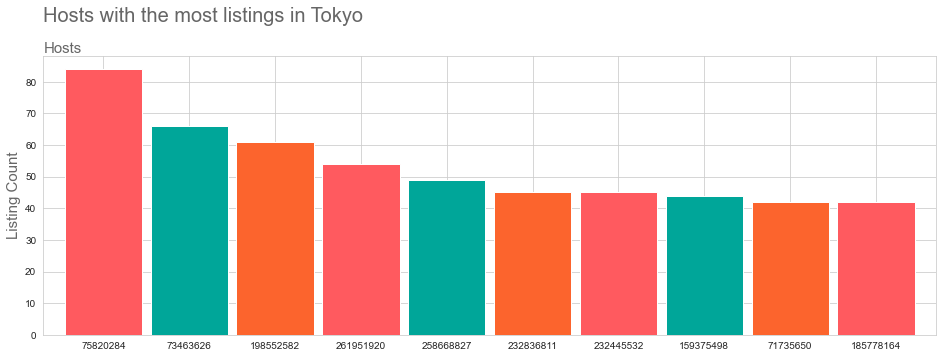

In [14]:
top_host=final.host_id.value_counts().head(10)

fig = plt.figure(1, figsize=(16,5))
ax = fig.add_subplot(111)

title = 'Hosts with the most listings in Tokyo'

transparency = 0.7
color = ['#FF5A5F', '#00A699', '#FC642D']

top_host.plot(kind = 'bar', 
              color = color, 
              width = 0.9,
              title = title)

# ax.grid(False)
# ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.1))

ax.xaxis.set_label_position('top')
xlab = 'Hosts'
ax.set_xlabel(xlab, fontsize=15, alpha=transparency, ha='left')
ax.xaxis.set_label_coords(0, 1.01)
plt.xticks(rotation=0)

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

<div class="alert alert-block alert-success">

<b>Observation:</b>

These are the host with most number of listing in Tokyo. Host 75820284 has over 80 listings. 


</div>

##### Neighbourhod

In [7]:
# Create new dataframe for neighbourhood count
neighbourhood_count = pd.DataFrame()
neighbourhood_count['total_hosts'] = final['neighbourhood_cleansed'].value_counts()

# Filter out neighbourhood with less than 20 listings
neighbourhood_count = neighbourhood_count[neighbourhood_count['total_hosts'] > 20]
neighbourhood_count.sort_index(ascending=True, inplace=True)

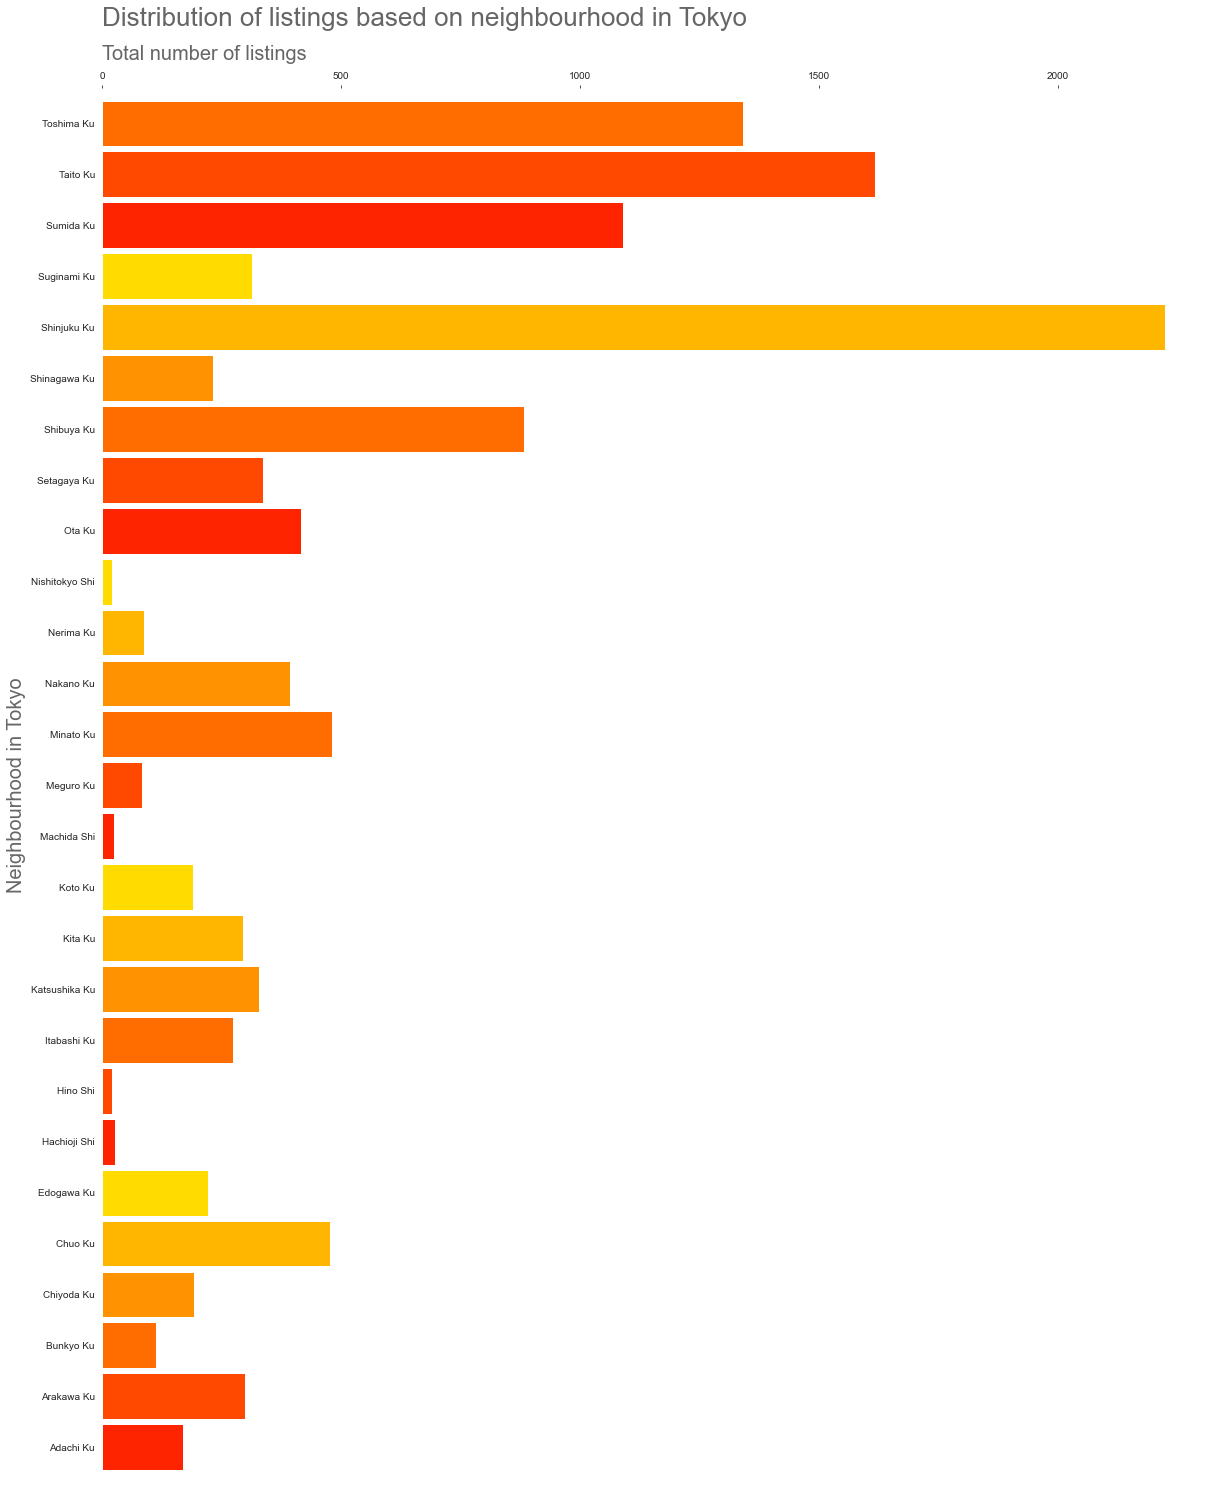

In [8]:
fig = plt.figure(1, figsize=(20,25))
ax = fig.add_subplot(111)

title="Distribution of listings based on neighbourhood in Tokyo"

transparency = 0.7
cmap = sns.color_palette("autumn")

neighbourhood_count['total_hosts'].plot(kind = 'barh',
                                        ax = ax,
                                        color = cmap,
                                        title = title, 
                                        width = 0.9)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=26, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))

ax.xaxis.set_label_position('top')
xlab = 'Total number of listings'
ax.set_xlabel(xlab, fontsize=20, alpha=transparency, ha='left')
ax.xaxis.set_label_coords(0, 1.02)
ax.xaxis.tick_top()

ylab = 'Neighbourhood in Tokyo'
ax.set_ylabel(ylab, fontsize=20, alpha=transparency);

<div class="alert alert-block alert-success">

<b>Observation:</b>

Top most popular neighbourhood - Shinjuku Ku, Taito Ku, Toshima Ku, Sumida Ku, and Shibuya Ku


</div>

##### Property Type

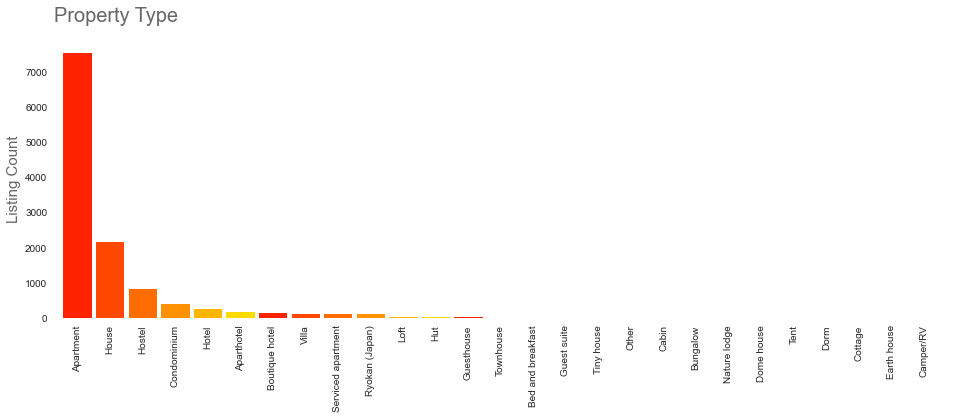

In [9]:
fig = plt.figure(1, figsize=(16,5))
ax = fig.add_subplot(111)

title = 'Property Type'

transparency = 0.7
color = sns.color_palette("autumn")

final['property_type'].value_counts().plot(kind='bar', 
                                           color = color, 
                                           width = 0.9,
                                           title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

<div class="alert alert-block alert-success">

<b>Observation:</b>

Most listings are Apartment 


</div>

##### Room Type

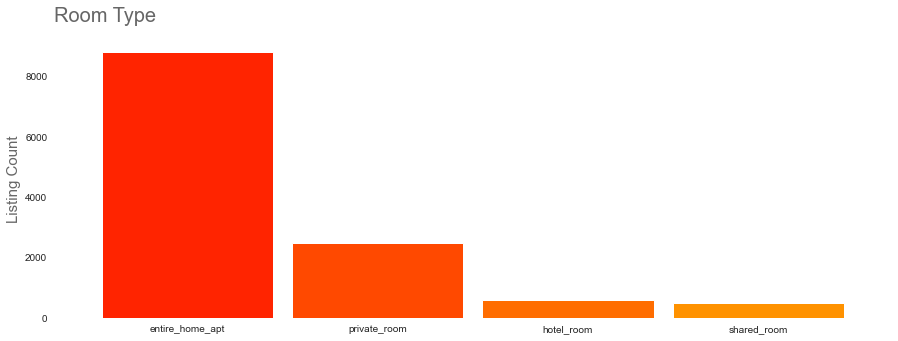

In [10]:
fig = plt.figure(1, figsize=(15,5))
ax = fig.add_subplot(111)

title = 'Room Type'

transparency = 0.7
color = sns.color_palette("autumn")

final['room_type'].value_counts().plot(kind='bar',
                                       color = color,
                                       width = 0.9, 
                                       title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))
plt.xticks(rotation=0)

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

##### Property Vs Room Type

In [11]:
# Create a dataframe with property_type and room_type
property_room = final.groupby(['property_type','room_type']).room_type.count().unstack()

# Sum up the total number of room types in a property type
property_room['total'] = property_room.iloc[:,0:4].sum(axis = 1)
property_room.sort_values(by='total', inplace=True)

# Filter out properties that are less than 100
property_room = property_room[property_room['total']>=100]
property_room = property_room.drop(['total'], axis=1)

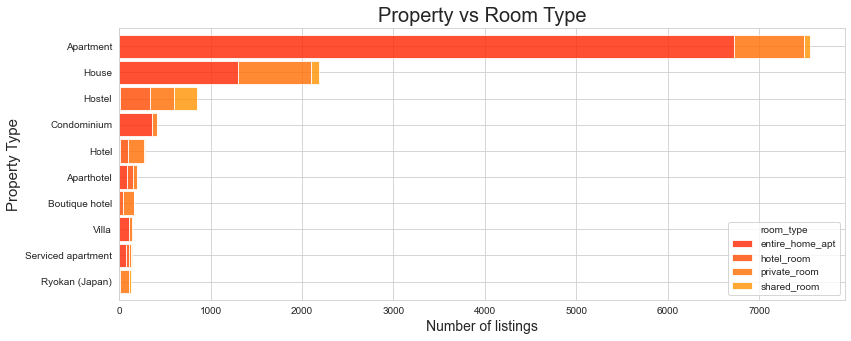

In [12]:
color = sns.color_palette("autumn")

property_room.plot(kind='barh',
                   stacked=True, 
                   color = color,
                   width=0.9,
                   figsize=(13,5), 
                   alpha = 0.8)

plt.title('Property vs Room Type', fontsize=20)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("Property Type", fontsize=15);

<div class="alert alert-block alert-success">

<b>Observation:</b>

As shown in the figure above, most listings are categorised as apartments which comes in 3 top room types which are entire home, hotel room, and private room


</div>

##### Accomodates

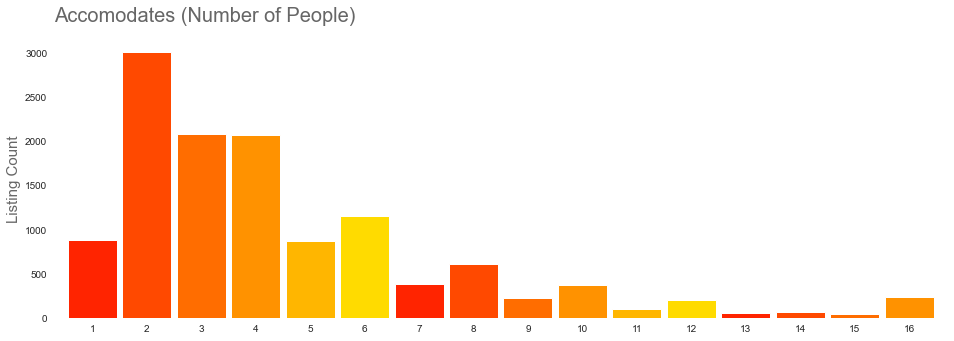

In [13]:
fig = plt.figure(1, figsize=(16,5))
ax = fig.add_subplot(111)

title = 'Accomodates (Number of People)'

transparency = 0.7
color = sns.color_palette("autumn")

final['accommodates'].value_counts().sort_index().plot(kind='bar', 
                                             color = color, 
                                             width = 0.9, 
                                             title = title)

ax.grid(False)
ax.set_frame_on(False)

ax.set_title(ax.get_title(), fontsize=20, alpha=transparency, ha='left')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0,1.04))
plt.xticks(rotation=0)

ylab = 'Listing Count'
ax.set_ylabel(ylab, fontsize=15, alpha=transparency);

<div class="alert alert-block alert-success">

<b>Observation:</b>

Most listings in Tokyo are for 2-4 people

</div>

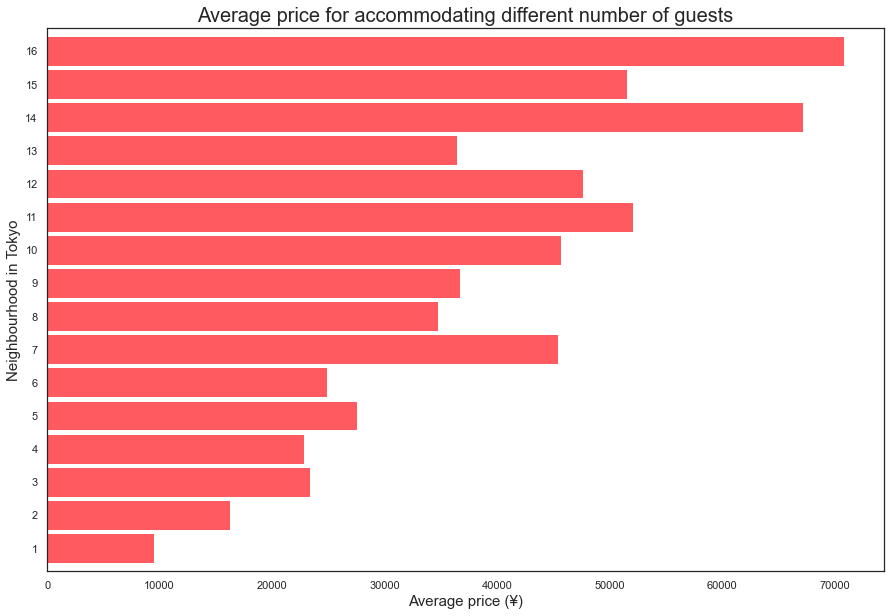

In [41]:
plt.figure(figsize=(15, 10))

color = '#FF5A5F'

final.groupby('accommodates').price.mean().plot.barh(color = color, 
                                                     width=0.9)

plt.title("Average price for accommodating different number of guests", fontsize=20)
plt.xlabel('Average price (¥)', fontsize=15)
plt.ylabel('Neighbourhood in Tokyo', fontsize=15);

##### Rooms

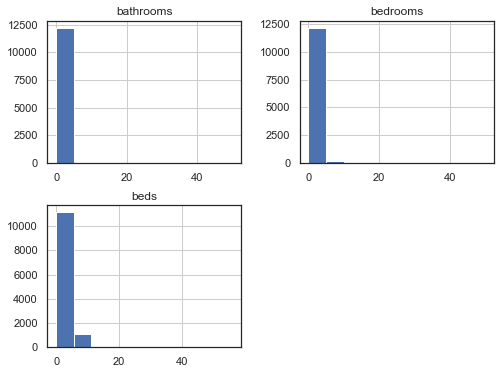

In [33]:
final[['bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

<div class="alert alert-block alert-success">

<b>Observation:</b>

There seem to have listing that are of zero value. On top of that, there are listing that are listed at outrages price

</div>

<div class="alert alert-block alert-warning">

<b>To Do:</b>

Remove Outlier:

- to drop prices that are priced at zero 
- to drop outrages price listings

</div>

##### Review_Scores

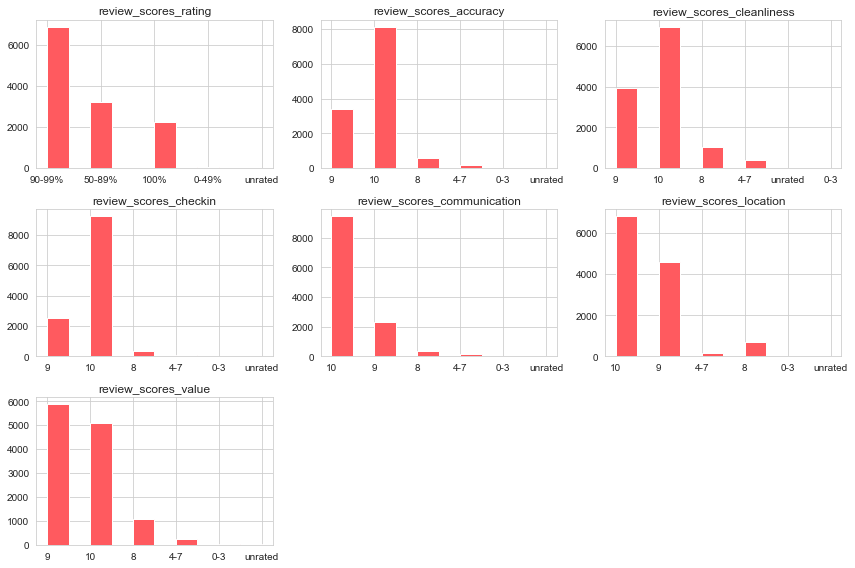

In [23]:
review_col = list(final.columns[final.columns.str.startswith("review_scores") == True])

fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(review_col):
    ax = fig.add_subplot(3,3,i+1)
    final[var_name].hist(bins=10, ax=ax, color = '#FF5A5F')
    ax.set_title(var_name)
    
fig.tight_layout()

##  3. Time Series Analysis

##### a. Time Since First Review

In [24]:
# final['time_since_first_review'] = final.last_review - final.first_review
# final.time_since_first_review.hist(figsize=(11,9), bins=30);

## 4. Multicollinearity

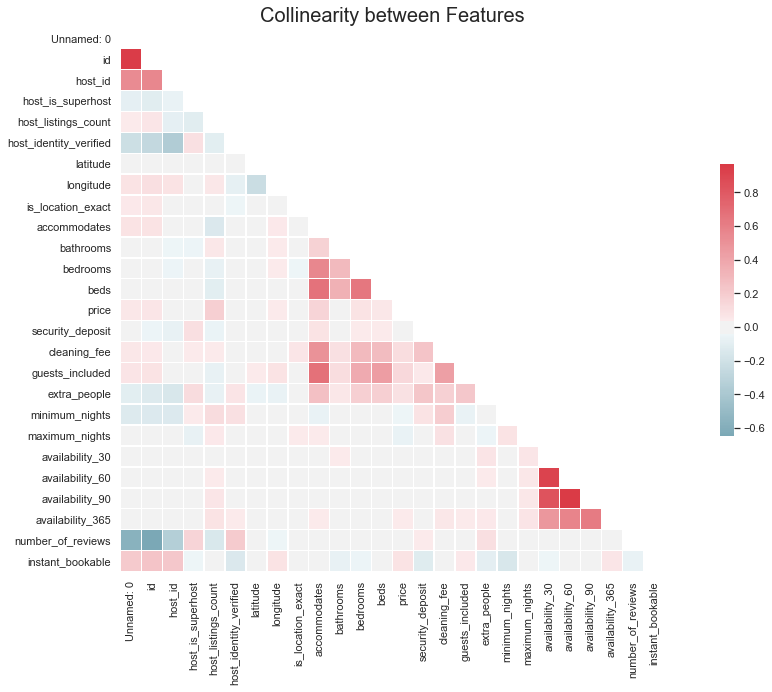

In [25]:
sns.set(style="white")

corr = final.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20,10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            vmax=corr[corr != 1.0].max().max())

ax.set_title('Collinearity between Features', fontsize=20);

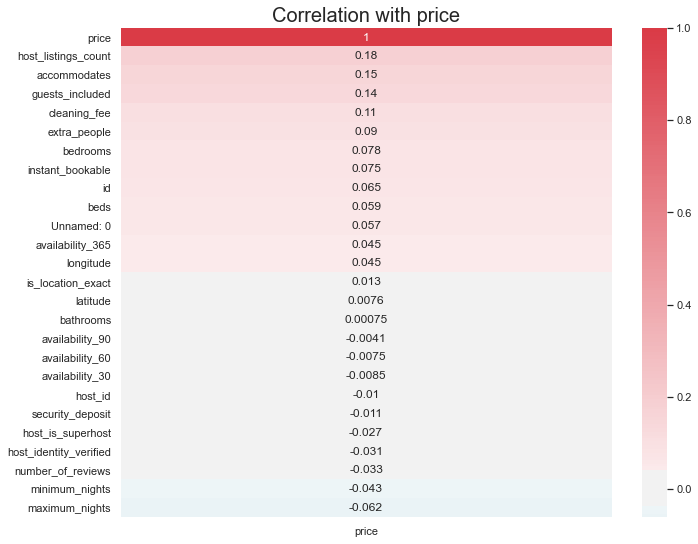

In [26]:
fig = plt.figure(figsize=(11,9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(final.corr()[['price']].sort_values(by='price', ascending=False), 
            cmap=cmap, 
            center=0, 
            annot=True)

plt.title('Correlation with price', fontsize=20)
y_min, y_max = ax.get_ylim() 
x_min, x_max = ax.get_xlim()
ax.set_ylim(top=y_max+1) 
ax.set_xlim(right=x_max-1);

<div class="alert alert-block alert-warning">

<b>EDA PLOTS:</b> 

1. Distribution of Review scores 

2. Distribution of listings based on neighbourhood in Tokyo
    - total number of listing (y-axis)
    - neighbourhood in Tokyo (x-axis)
    
3. Popularity of room types in property types

4. see if there is any trend on bookings? (seasonality)

5. listings per host

6. property, room type on price
    

</div>

### <span style='background:yellow'> 2. Feature Engineering </span>  --- to break notebook

##### a. Categorical Variables

In [27]:
# final = pd.get_dummies(final, columns=['property_type',
#                                            'room_type',
#                                            'cancellation_policy', 
#                                            'neighbourhood_cleansed',
#                                            'host_response_time'], 
#                          drop_first = False)
# final.shape

##### b. Amenities

In [28]:
all_amenities = final['amenities'].str.get_dummies(sep=',')

In [29]:
all_amenities = pd.concat([final.price, all_amenities], axis=1)

In [30]:
all_amenities.head()

,price,toilet,24-hour check-in,accessible-height bed,accessible-height toilet,air conditioning,air purifier,baby bath,baby monitor,babysitter recommendations,...,well-lit path to entrance,wheelchair accessible,wide clearance to shower,wide doorway to guest bathroom,wide entrance,wide entrance for guests,wide entryway,wide hallways,wifi,window guards
0,4192,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,10965,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,4192,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6987,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3977,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


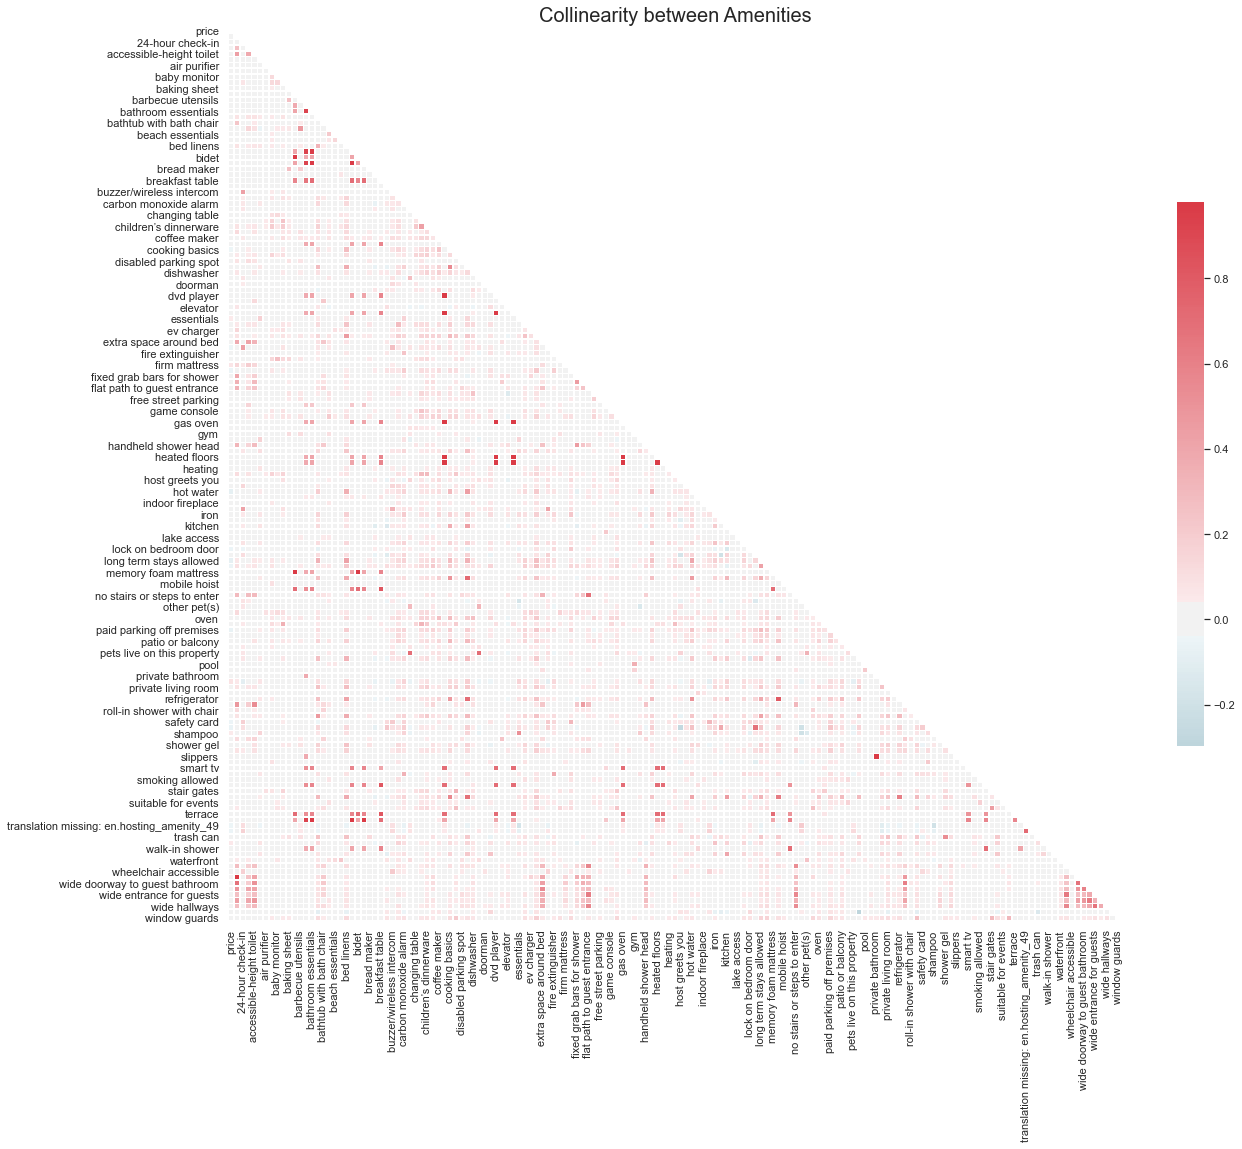

In [31]:
sns.set(style="white")

corr = all_amenities.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            vmax=corr[corr != 1.0].max().max());

ax.set_title('Collinearity between Amenities', fontsize=20);